In [32]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from joblib import dump, load

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

## Importing data and preparing it for ML

In [34]:
#import cleaned data
df = pd.read_csv("../Data/AB_data_clean.csv")
df.head(2)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,neighbourhood_other,neighbourhood_other_label,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,...,Other,29,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,...,Midtown,25,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [35]:
#manage Na values in dataframe
df.isna().sum()

id                                      0
name                                   15
host_id                                 0
host_name                              21
neighbourhood_group                     0
neighbourhood                           0
latitude                                0
longitude                               0
room_type                               0
price                                   0
minimum_nights                          0
number_of_reviews                       0
last_review                          9913
reviews_per_month                    9913
calculated_host_listings_count          0
availability_365                        0
neighbourhood_other                     0
neighbourhood_other_label               0
neighbourhood_group_Bronx               0
neighbourhood_group_Brooklyn            0
neighbourhood_group_Manhattan           0
neighbourhood_group_Queens              0
neighbourhood_group_Staten Island       0
room_type_Entire home/apt         

In [36]:
print(df[df['last_review'].isna()].groupby('number_of_reviews').size())
print(df[df['reviews_per_month'].isna()].groupby('number_of_reviews').size())

number_of_reviews
0    9913
dtype: int64
number_of_reviews
0    9913
dtype: int64


In [37]:
df['last_review'] = df['last_review'].fillna(0)
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)

In [41]:
#chose which featues not to include in the calculation
features = df.drop(['price',
                    'id', 
                    'name', 
                    'host_id', 
                    'host_name', 
                    'neighbourhood_group',
                    'neighbourhood', 
                    'room_type',
                    'last_review',#dropped until we encode it to not datetime
                    'neighbourhood_other'], axis=1)
target = df.price

print(features.columns)

Index(['latitude', 'longitude', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'neighbourhood_other_label',
       'neighbourhood_group_Bronx', 'neighbourhood_group_Brooklyn',
       'neighbourhood_group_Manhattan', 'neighbourhood_group_Queens',
       'neighbourhood_group_Staten Island', 'room_type_Entire home/apt',
       'room_type_Private room', 'room_type_Shared room'],
      dtype='object')


## Random forest for the website

In [65]:
features_web = features.drop(['reviews_per_month',
                              'neighbourhood_other_label',
                              'neighbourhood_group_Bronx',
                              'neighbourhood_group_Brooklyn',
                              'neighbourhood_group_Manhattan', 
                              'neighbourhood_group_Queens',
                              'neighbourhood_group_Staten Island'], axis=1)
target = df.price

print(features_web.columns)

Index(['latitude', 'longitude', 'minimum_nights', 'number_of_reviews',
       'calculated_host_listings_count', 'availability_365',
       'room_type_Entire home/apt', 'room_type_Private room',
       'room_type_Shared room'],
      dtype='object')


In [66]:
test_fraction = 0.2

# This is a stratified split:
X_train, X_test, y_train, y_test = train_test_split(features_web, target, test_size = test_fraction, random_state=3546)
#Display how many samples are chosen for training and test, respectively
print('Training Features Shape:', X_train.shape,'\tTesting Features Shape:\t', X_test.shape)
print('Training Labels Shape:\t', y_train.shape, '\tTesting Labels Shape:\t', y_test.shape)

Training Features Shape: (38970, 9) 	Testing Features Shape:	 (9743, 9)
Training Labels Shape:	 (38970,) 	Testing Labels Shape:	 (9743,)


In [67]:
parameters = {'n_estimators':[10, 50, 100, 150, 200], 'criterion':('mse',), 'max_depth':[10, 20, None]} # mae is again more than 60 times slower than mse

reg_forest_web = RandomForestRegressor(random_state=3546) # random state is set so as to guarantee the same outcome every time
reg_seach = GridSearchCV(reg_forest_web, parameters, scoring='neg_mean_absolute_error', refit=True, )#verbose=4)

reg_seach.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestRegressor(random_state=3546),
             param_grid={'criterion': ('mse',), 'max_depth': [10, 20, None],
                         'n_estimators': [10, 50, 100, 150, 200]},
             scoring='neg_mean_absolute_error')

In [68]:
df_reg_forest_web = pd.DataFrame(reg_seach.cv_results_).sort_values('rank_test_score')
df_reg_forest_web.head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,17.098092,1.426560,0.198983,0.019181,mse,10,150,"{'criterion': 'mse', 'max_depth': 10, 'n_estim...",-67.058696,-67.740407,-68.501693,-67.115527,-66.988532,-67.480971,0.576809,1
4,23.541994,1.949108,0.301652,0.024079,mse,10,200,"{'criterion': 'mse', 'max_depth': 10, 'n_estim...",-67.054049,-67.755101,-68.531991,-67.108138,-66.959011,-67.481658,0.595566,2


In [69]:
reg_forest_web_best = reg_seach.best_estimator_
y_pred = reg_forest_web_best.predict(X_test)

print(f'Mean absolute error (on test data): {round(mean_absolute_error(y_test, y_pred),4)}')

Mean absolute error (on test data): 68.7354


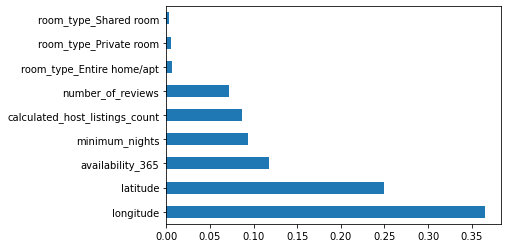

In [70]:
pd.Series(reg_forest_web_best.feature_importances_, index=features_web.columns).nlargest(20).plot(kind='barh')
plt.show()

In [71]:
dump(reg_forest_web_best, 'model_forest_web.joblib')

['model_forest_web.joblib']